# Imports

In [14]:
from load_dataset import load_dataset
from create_dataloader import create_dataloader
from preprocess import crop_images, gland_type_division
from model import computeAUCs,train_model,createFTNetworkGoogLeNet,test_model

import matplotlib.pyplot as plt
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# MODEL TRAINING

## Load data

In [15]:
!pip install openpyxl

In [16]:
file_path = "./Imágenes + Labels"
images_path= file_path
csv_path= file_path+ "/Anonymized images_student.xlsx"
images, image_data = load_dataset(images_path,csv_path)

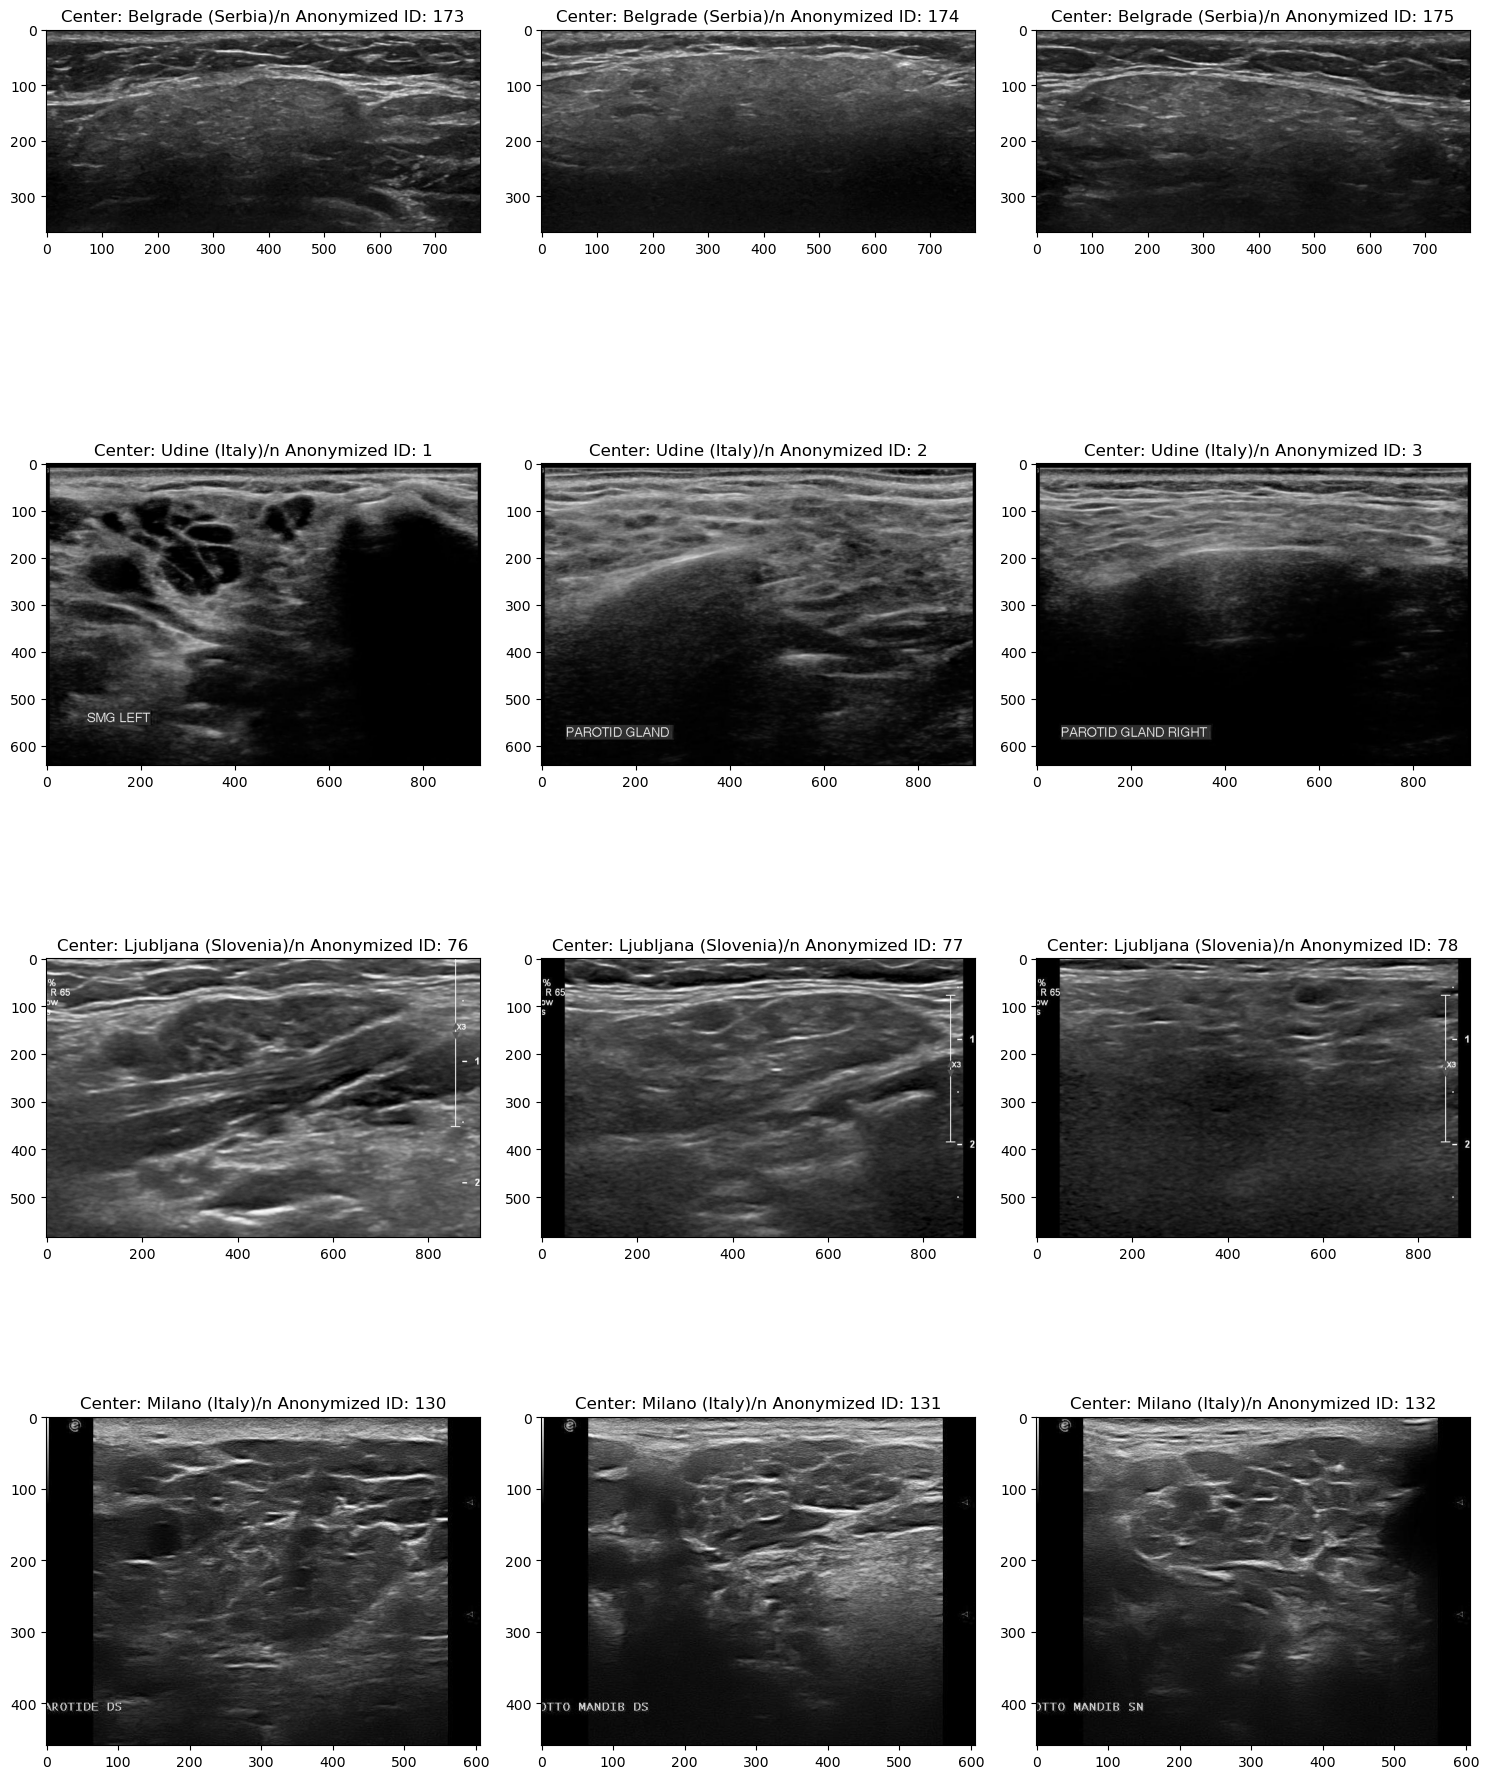

In [17]:
centers=set(image_data['Center'])
fig, axes = plt.subplots(nrows=len(centers), ncols=3, figsize=(15, 5*len(centers)))
for i, center in enumerate(centers):
  image_data_center = image_data[image_data['Center'] == center]

  for j in range(3):
        # Get the image data for the current row
        keys_example = image_data_center.iloc[j]['Anonymized ID']
        im_example=images[keys_example]
        # Plot the image on the corresponding axis
        axes[i, j].imshow(im_example, cmap='gray')
        axes[i, j].set_title(f'Center: {center}/n Anonymized ID: {keys_example}')


plt.tight_layout()
plt.show()

## Crop images

In [18]:
cropped_images = crop_images(images, image_data, x_size=497, y_size=365)

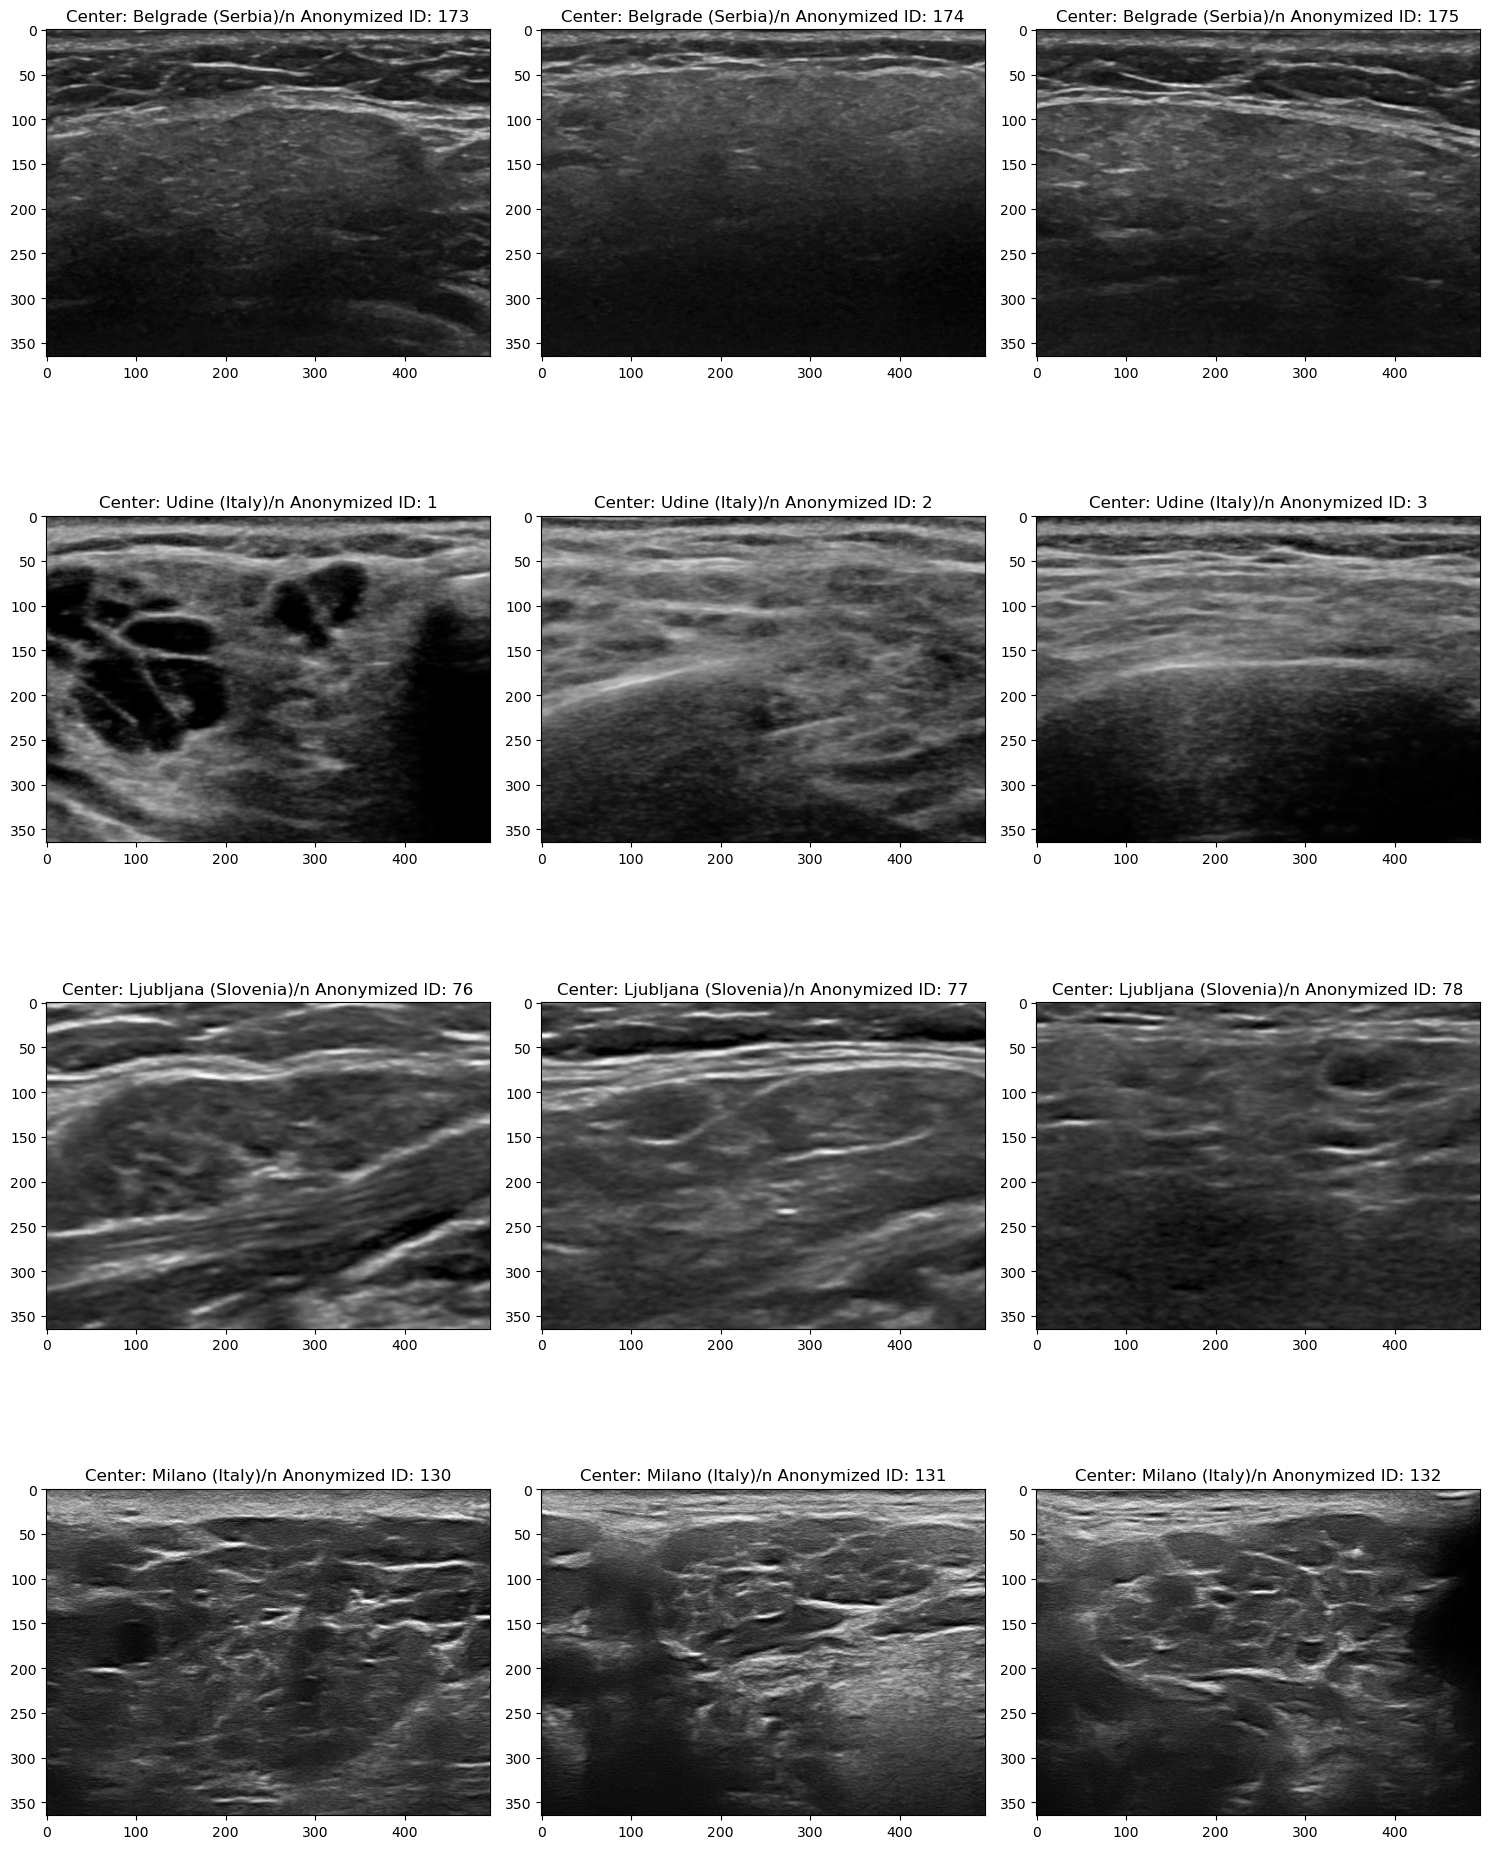

In [19]:
centers=set(image_data['Center'])
fig, axes = plt.subplots(nrows=len(centers), ncols=3, figsize=(15, 5*len(centers)))
for i, center in enumerate(centers):
  image_data_center = image_data[image_data['Center'] == center]

  for j in range(3):
        # Get the image data for the current row
        keys_example = image_data_center.iloc[j]['Anonymized ID']
        im_example=cropped_images[keys_example]
        # Plot the image on the corresponding axis
        axes[i, j].imshow(im_example, cmap='gray')
        axes[i, j].set_title(f'Center: {center}/n Anonymized ID: {keys_example}')


plt.tight_layout()
plt.show()

# Train and val split

In [20]:
from sklearn.model_selection import train_test_split  
groups = image_data.groupby('Patient ID').size().reset_index(name='counts')
train_patient_ids, val_patient_ids = train_test_split(groups['Patient ID'], test_size=0.3, random_state=42)

anonimyzed_ID=image_data['Anonymized ID'].tolist()
anonimyzed_ID_train=[anonimyzed_ID[train_id] for train_id in train_patient_ids]
anonimyzed_ID_val=[anonimyzed_ID[val_id] for val_id in val_patient_ids]

In [21]:
x_train = []
x_val = []
x_train_parotid = []
x_train_subm = []
x_val_parotid = []
x_val_subm = []
y_train = []
y_val = []
y_train_parotid = []
y_train_subm = []
y_val_parotid = []
y_val_subm = []

# Iterate over the DataFrame to populate the lists
for index, row in image_data.iterrows():
    anonymized_id = row['Anonymized ID']
    image = cropped_images.get(anonymized_id)
    omeract_score = row['OMERACT score']
    
    if anonymized_id in anonimyzed_ID_train:
        x_train.append(image)
        y_train.append(omeract_score)
        if row['parotid/submandibular'] == 'parotid':
            x_train_parotid.append(image)
            y_train_parotid.append(omeract_score)
        elif row['parotid/submandibular'] == 'submandibular':
            x_train_subm.append(image)
            y_train_subm.append(omeract_score)
    elif anonymized_id in anonimyzed_ID_val:
        x_val.append(image)
        y_val.append(omeract_score)
        if row['parotid/submandibular'] == 'parotid':
            x_val_parotid.append(image)
            y_val_parotid.append(omeract_score)
        elif row['parotid/submandibular'] == 'submandibular':
            x_val_subm.append(image)
            y_val_subm.append(omeract_score)

## Dataset & dataloader creation

In [22]:

train_dataset, train_loader = create_dataloader(x_train, y_train, batch_size=8, dataloader_type="train", target_size = (365, 496))
train_subm_dataset,train_subm_loader = create_dataloader(x_train_subm, y_train_subm, batch_size=8, dataloader_type="train", target_size = (365, 496))
train_parotid_dataset,train_parotid_loader = create_dataloader(x_train_parotid, y_train_parotid, batch_size=8, dataloader_type="train", target_size = (365, 496))

val_dataset, val_loader = create_dataloader(x_val, y_val, batch_size=8, dataloader_type="val", target_size = (365, 496))
val_subm_dataset,val_subm_loader = create_dataloader(x_val_subm, x_val_subm, batch_size=8, dataloader_type="val", target_size = (365, 496))
val_parotid_dataset,val_parotid_loader = create_dataloader(x_val_parotid, y_val_parotid, batch_size=8, dataloader_type="val", target_size = (365, 496))


In [23]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}
dataloaders = {'train' : train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


image_datasets_subm = {'train' : train_subm_dataset, 'val': val_subm_dataset}
dataloaders_subm = {'train' : train_subm_loader, 'val': val_subm_loader}
dataset_sizes_subm = {'train': len(train_subm_dataset), 'val': len(val_subm_dataset)}


image_datasets_parotid = {'train' : train_dataset, 'val': val_dataset}
dataloaders_parotid = {'train' : train_parotid_loader, 'val': val_parotid_loader}
dataset_sizes_parotid = {'train': len(train_parotid_dataset), 'val': len(val_parotid_dataset)}

## Pretrained model fine tuning: Google LeNET

### Fine tunining for submadibular and parotid glands together

In [24]:
ftNet = createFTNetworkGoogLeNet()
ftNet = ftNet.to(device)

In [25]:

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

#Create the network and pass to the GPU
ftNet = createFTNetworkGoogLeNet()
ftNet = ftNet.to(device)

#Loss function
criterion = nn.CrossEntropyLoss()

#ADAM optimizer
optimizer_ft = optim.Adam(ftNet.parameters(),lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.1)


ftNet = train_model(dataloaders, dataset_sizes, ftNet, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=2)

Epoch 0/1
----------
Labels = tensor([3, 0, 2, 2, 0, 0, 2, 3])
Outputs = tensor([[ 0.1378, -0.0408,  0.0595,  0.0193],
        [-0.2856, -0.0010, -0.0025, -0.1205],
        [-0.0998,  0.3974,  0.1684, -0.1892],
        [-0.0084, -0.1551,  0.0236, -0.2849],
        [ 0.0168, -0.1206,  0.0483, -0.0553],
        [-0.3016, -0.1383,  0.0417, -0.3780],
        [-0.0434,  0.1863,  0.2350, -0.3228],
        [ 0.0709,  0.0005,  0.0491,  0.0394]], grad_fn=<AddmmBackward0>)
Labels = tensor([3, 1, 3, 0, 0, 1, 3, 0])
Outputs = tensor([[ 0.1212, -0.4188, -0.0420, -0.1754],
        [-0.0309, -0.1060, -0.3075, -0.2974],
        [ 0.1280,  0.0213,  0.1483, -0.1646],
        [ 0.0748, -0.0500, -0.0639, -0.1888],
        [ 0.0121,  0.0452,  0.0136, -0.2543],
        [ 0.0501, -0.0912,  0.2457, -0.1310],
        [ 0.0640,  0.0928,  0.3115, -0.1426],
        [-0.1943, -0.2838,  0.2641, -0.1482]], grad_fn=<AddmmBackward0>)
Labels = tensor([2, 0, 0, 0, 3, 0, 2, 2])
Outputs = tensor([[ 0.1005, -0.0499,  0.410

In [ ]:
torch.save(ftNet.state_dict(), "model_weights_general")

#### Fine tuning the previous model for submandibular glands

In [26]:
ftNet_general_submandibular = train_model(dataloaders_subm, dataset_sizes_subm, ftNet, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=2)

Epoch 0/1
----------
Labels = tensor([1, 0, 0, 0, 0, 0, 0, 0])
Outputs = tensor([[ 0.2036, -0.3709, -0.4148, -0.1976],
        [ 0.5773, -0.6252, -0.3823,  0.0430],
        [ 0.8440, -0.4529, -0.2838, -0.2645],
        [ 0.3198, -0.5712, -0.1601,  0.0458],
        [ 0.4677, -0.2931,  0.3041, -0.8046],
        [ 0.5624, -0.7045, -0.0949, -0.3214],
        [ 0.7253, -0.3827, -0.0956, -0.1683],
        [ 0.8333, -0.7130, -0.5016,  0.0272]], grad_fn=<AddmmBackward0>)
Labels = tensor([0, 0, 0, 0, 0, 3, 0, 0])
Outputs = tensor([[ 0.4551, -0.4007, -0.1825,  0.0014],
        [ 0.6764, -0.7068, -0.1301, -0.4118],
        [ 0.4754, -0.3171, -0.2099,  0.1287],
        [ 0.6771, -0.4116, -0.0105, -0.2629],
        [ 0.6416, -0.5647, -0.3517, -0.4847],
        [ 0.4125, -0.6294, -0.0328,  0.0433],
        [ 0.3718, -0.4852, -0.3211, -0.2587],
        [ 0.4634, -0.6338, -0.2391, -0.0230]], grad_fn=<AddmmBackward0>)
Labels = tensor([1, 0, 0, 2, 0, 0, 0, 3])
Outputs = tensor([[ 0.3533, -0.4452, -0.053

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [14]:

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(ftNet_general_submandibular.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.1)

ftNet_general_submandibular = train_model(dataloaders_subm, dataset_sizes_subm, ftNet_general_submandibular, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=25)

Epoch 0/24
----------
train
train Loss: 1.4175 AUC OMERACT 0: 0.9861 OMERACT 1: 0.6957 OMERACT 2: 0.8000 OMERACT 3: 0.9935 avg: 0.8688
val


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
torch.save(ftNet_general_submandibular.state_dict(), "model_weights_general_submandibular")

#### Fine tuning the previous model for only submandibular glands

In [ ]:
state_dict_general = torch.load("model_weights_general")
ftNet_general_parotid = createFTNetworkGoogLeNet()
ftNet_general_parotid.load_state_dict(state_dict_general)

In [ ]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = False


criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(ftNet_general_parotid.parameters(),lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.1)


ftNet_general_parotid = train_model(dataloaders_parotid, dataset_sizes_parotid, ftNet_general_parotid, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=25)

In [ ]:
torch.save(ftNet_general_parotid.state_dict(), "model_weights_general_parotid")

## Fine tuning exclusively for submandibular glands

In [ ]:

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

#Create the network and pass to the GPU
ftNet_submandibular = createFTNetworkGoogLeNet()
ftNet_submandibular = ftNet_submandibular.to(device)

#Loss function
criterion = nn.CrossEntropyLoss()

#ADAM optimizer
optimizer_ft = optim.Adam(ftNet_submandibular.parameters(),lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.1)


ftNet_submandibular = train_model(dataloaders_subm, dataset_sizes_subm, ftNet_submandibular, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=25)

## Fine tuning exclusively for parotid glands

In [ ]:

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

#Create the network and pass to the GPU
ftNet_parotid = createFTNetworkGoogLeNet()
ftNet_parotid = ftNet_parotid.to(device)


criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(ftNet_parotid.parameters(),lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.1)


ftNet_parotid = train_model(dataloaders_parotid, dataset_sizes_parotid, ftNet_parotid, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=25)

# MODEL EVALUATION

In [ ]:
test_images_path = #Fill with the test image file path 
test_xlsx_path= #Fill with the xlsx iamge file path 
test_images, test_image_data = load_dataset(test_images_path,test_xlsx_path)

In [ ]:
cropped_images_test = crop_images(test_images, test_image_data, x_size=497, y_size=365)

In [ ]:
submandibular_images, submandibular_labels, parotid_images, parotid_labels = gland_type_division(cropped_images_test,test_image_data)

In [ ]:

train_subm_dataset,train_parotid_loader = create_dataloader(submandibular_images, submandibular_labels, batch_size=8, dataloader_type="test", target_size = (365, 496))
train_parotid_dataset,train_subm_loader = create_dataloader(parotid_images, parotid_labels, batch_size=8, dataloader_type="test", target_size = (365, 496))

In [ ]:
test_model(model, test_dataset, test_dataloader, device)